<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/Crisp%20and%20Fuzzy%20K-means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сначала сгенерируем 2100 точек, принадлежащих 7 перекрывающимся кластерам  с помощью make_blobs. На рисунке ниже нарисовано распределение точек и истинные метки кластеров помеченные семью разными цветами:

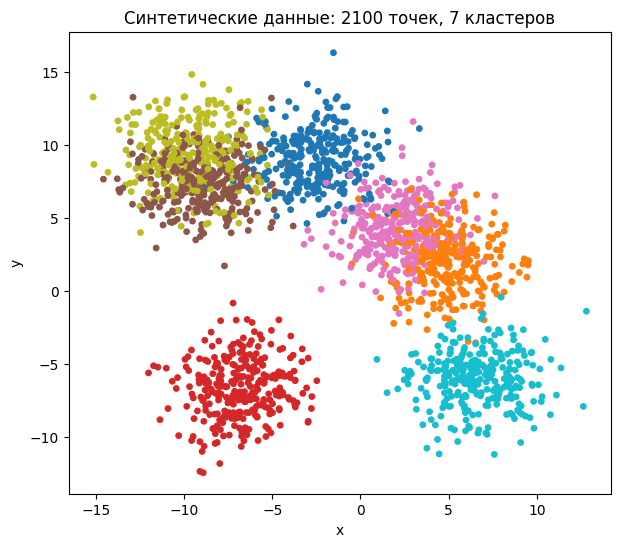

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Генерируем данные 2100 точек, 7 кластеров, увеличенная дисперсия для перекрытия
np.random.seed(42)
X, true_labels = make_blobs(n_samples=2100, centers=7, cluster_std=1.9, random_state=42)

# Пример визуализации с истинными метками
plt.figure(figsize=(7,6))
plt.scatter(X[:,0], X[:,1], c=true_labels, s=15, cmap='tab10') #c - отв за цвет кластера, s - р-р точки, cmap - выбор палитры
plt.title("Синтетические данные: 2100 точек, 7 кластеров")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


##Алгоритм K-Means с евклидовым расстоянием.

Алгоритм k-средних разбивает данные на K кластеров с помощью итеративного пересчёта центроидов кластеров (центр кластера – среднее всех точек в кластере) и распределения точек по ближайшим центрам. Цель алгоритма k-means: минимизировать внутрикластерную дисперсию, то есть сумму квадратов расстояний всех точек до центров своих кластеров

$$
J = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

  Где:
  - $ k $ — количество кластеров  
  - $C_i $ — множество точек, отнесённых к кластеру \( i \)  
  - $mu_i$ — центр кластера \( i \)  
  - $|x - \mu_i\|^2 $ — квадрат евклидова расстояния от точки до центра

## Нахождение центроидов и перераспределение по классам

1. Инициализация  
  Необходимо инициализировать количество центров кластеров k, поскольку k-means необходимо заранее знать кол-во центроидов. Алгоритм как бы случайно выбирает начальные центроиды.

2. Вычисление расстояний
   Для каждой точки рассчитывается евклидово расстояние до каждого центра:

   $$
   l_{ij} = \|x_j - \mu_i\| = \sqrt{ \sum_{d=1}^{n} (x_{jd} - \mu_{id})^2 }
   $$

   Где:
   - $ l_{ij} $ — расстояние от точки \( x_j \) до центра кластера \( \mu_i \)  
   - $ x_{jd} $ — координата точки \( j \) по оси \( d \)  
   - $\mu_{id} $ — координата центра \( i \) по оси \( d \)  
   - $ n $ — размерность пространства (например, 2D или 3D)

3. Назначение кластеров
   Алгоритм относит точку к тому кластеру, чей центр ближе всего к точке:

   $$
   \text{cluster}(x_j) = \arg\min_{i} \|x_j - \mu_i\|
   $$

4. Обновление центров кластеров  
   После перераспределения точек центры пересчитываются как среднее всех точек в кластере:

   $$
   \mu_i = \frac{1}{|C_i|} \sum_{x \in C_i} x
   $$

   Где:  
   - $|C_i| $ — количество точек в кластере \( i \)  
   - $\mu_i $ — «центр масс» точек кластера

5. Проверка на сходимость  
   Алгоритм повторяет шаги 2–4, пока центры кластеров не перестанут меняться.

In [ ]:
import time
from sklearn.metrics import adjusted_rand_score, silhouette_score

def kmeans_custom(X, k, max_iter=100, tol=1e-6):
    np.random.seed(0)
    # случайно выбираем k начальных центроидов из данных
    init_idx = np.random.choice(X.shape[0], k, replace=False)
    centers = X[init_idx].astype(float)
    centers_history = [centers.copy()]
    for it in range(max_iter):
        # вычисл евклидовы расстояния до каждого центра - формула из 2 пункта
        dist = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
        # распределяем точки по ближайшему центру
        labels = np.argmin(dist, axis=1)
        # пересчитываем центры: среднее по точкам каждого кластера
        new_centers = np.array([
            X[labels==j].mean(axis=0) if np.any(labels==j) else centers[j]
            for j in range(k)
        ])
        centers_history.append(new_centers.copy())
        # проверка сходимости по изменению центров
        if np.allclose(new_centers, centers, atol=tol):
            centers = new_centers
            break
        centers = new_centers
    return centers, labels, it+1, centers_history

# запускаем k- means на наших данных
start = time.time()
k = 7
centers_k, labels_k, iter_k, centers_hist_k = kmeans_custom(X, k, max_iter=100)
time_k = time.time() - start

ari_k = adjusted_rand_score(true_labels, labels_k)
sil_k = silhouette_score(X, labels_k)

print(f"KMeans: время = {time_k:.3f} c, итераций = {iter_k}")
print(f"Adjusted Rand Index = {ari_k:.3f}, Silhouette Score = {sil_k:.3f}")


KMeans: время = 0.025 c, итераций = 18
Adjusted Rand Index = 0.652, Silhouette Score = 0.480


На рисунке 2 изображены траектории движения центров кластеров по итерациям (разные цвета – разные центры). Каждая траектория начинается в начальном случайном положении (см. точка начала цвета) и заканчивается в финальном положении центра. Хорошая визуализация показавает, как центры сходятся к «ядрам» кластеров

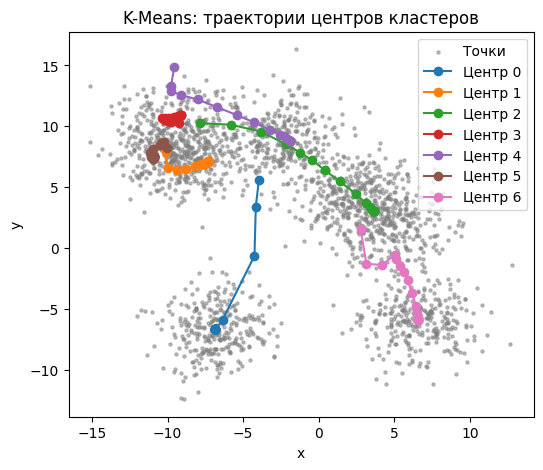

In [ ]:
# Визуализация траекторий центроидов
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c='gray', s=5, alpha=0.5, label='Точки')
colors = plt.cm.tab10(np.arange(k))
for j in range(k):
    traj = np.array([cent[j] for cent in centers_hist_k])
    plt.plot(traj[:,0], traj[:,1], '-o', color=colors[j], label=f'Центр {j}')
plt.title("K-Means: траектории центров кластеров")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


После сходимости можно визуализировать итоговое разбиение.

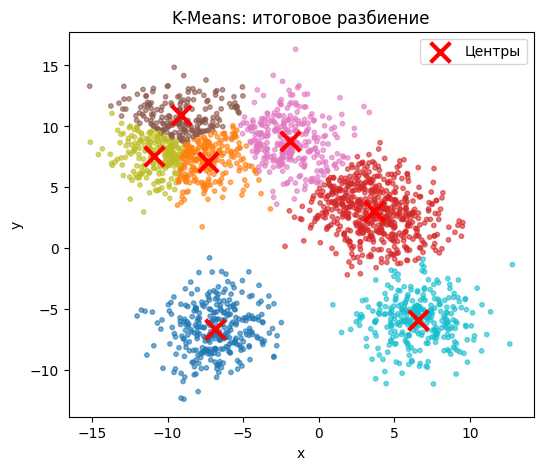

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=labels_k, s=10, cmap='tab10', alpha=0.6)
plt.scatter(centers_k[:,0], centers_k[:,1], s=200, c='red', marker='x', linewidths=3, label='Центры')
plt.title("K-Means: итоговое разбиение")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


In [ ]:
import numpy as np

# labels — результат работы kmeans_custom или другого k-means
centers, labels, iters, centers_history = kmeans_custom(X, k=7)
unique, counts = np.unique(labels, return_counts=True)

print("Количество точек в каждом кластере (k-means):")
for label, count in zip(unique, counts):
    print(f"Кластер {label}: {count} точек")


Количество точек в каждом кластере (k-means):
Кластер 0: 300 точек
Кластер 1: 227 точек
Кластер 2: 560 точек
Кластер 3: 195 точек
Кластер 4: 296 точек
Кластер 5: 215 точек
Кластер 6: 307 точек


# Метод с использованием нечёткого расстояния Gustafson–Kessel Fuzzy C-Means (FCM-GK):
    
Расстояние $D_ij$ задаётся матрицей $A_i$, зависящей от нечёткой ковариации кластера

Обычный FCM использует евклидово расстояние, поэтому кластеры получаются “круглыми” (в общем случае — сферическими). GK-FCM делает метрику кластер-специфичной: у каждого кластера своя матрица расстояния, которая подстраивается под форму кластера - эллипсоид.
Вместо одной метрики на все кластеры GK-FCM учится разным метрикам для каждого кластера на основе нечётких принадлежностей.

## Данные, принадлежности и центры
Набор данных:
$$
X = \{x_1, x_2, \dots, x_n\}, \quad x_j \in \mathbb{R}^d
$$
* $d$ - размерность пространства признаков  
* $n$ - кол-во точек

Число кластеров:
$$
c \in \mathbb{N}
$$

Матрица принадлежностей:
$$
U =
\begin{pmatrix}
\mu_{11} & \mu_{12} & \mu_{13} & \dots & \mu_{1n} \\
\mu_{21} & \mu_{22} & \mu_{23} & \dots & \mu_{2n} \\
\vdots   & \vdots   & \vdots   & \ddots & \vdots \\
\mu_{c1} & \mu_{c2} & \mu_{c3} & \dots & \mu_{cn}
\end{pmatrix}
$$
* строки соответствуют кластерам;
* столбцы соответствуют точкам данных;
* элементы — это степень принадлежности точки к кластеру

Нормировка принадлежностей по кластерам нужна чтобы сумма вероятностей принадлежности точки по всем кластерам была равна единице.
$$
\sum_{i=1}^{c} \mu_{ij} = 1, \quad j = 1,2,\dots,n
$$

Параметр нечёткости(fuzzifier) определяет, насколько сильно алгоритм будет размывать принадлежность точек к кластерам.
* маленький m - почти жёсткая кластеризация. При m = 1 формула неустойчива
* большой m - мягкая, размытая кластеризация.
$$
m > 1
$$

Центры кластеров:
$$
v_i \in \mathbb{R}^d, \quad i = 1,2,\dots,c
$$

## Ключевое отличие: расстояние в GK-FCM
В GK-FCM расстояние между точкой и кластером задаётся не просто нормой, а квадратичной формой:

$$
D_{ij}^2 = (x_j - v_i)^T A_i (x_j - v_i)
$$
* $A_i$ — матрица метрики для $i$-го кластера (симметричная, положительно определённая). Это кластер-специфичная матрица метрики, которая определяет, как измеряется расстояние от точек до i-го кластера.
В GK-FCM:
* у каждого кластера своя метрика
* расстояние до кластера зависит не только от центра, но и от формы кластера
* кластеры могут быть вытянутыми, повернутыми, эллиптическими.

$$
A_i \in \mathbb{R}^{d \times d}
$$

То есть если $A_i = I$, то это обычное евклидово расстояние, а если $A_i$ не единичная, то расстояние “растягивается/сжимается” по разным направлениям, то есть кластер становится эллипсоидом.

## Целевая функция GK-FCM
Расстояния зависят от $A_i$:
$$
J_m(U,V,A) = \sum_{i=1}^{c}\sum_{j=1}^{n}\mu_{ij}^{m}\,D_{ij}^{2}
$$
Подставляя расстояние:
$$
J_m(U,V,A) = \sum_{i=1}^{c}\sum_{j=1}^{n}\mu_{ij}^{m}\,(x_j - v_i)^T A_i (x_j - v_i)
$$

Если просто взять $A_i = F_i^{-1}$, масштаб кластера будет “съезжать” (кластер может сжиматься/раздуваться чисто чтобы оптимизировать вычисления). GK-FCM добавляет нормировку по детерминанту, чтобы фиксировать объём эллипсоида рассеивания(кластера). Если $det$ большой, значит кластер большой, если маленький, то и кластер маленький.

Формула GK:
$$
A_i = \left(\det(F_i)\right)^{\frac{1}{d}}\,F_i^{-1}
$$

* $F_i^{-1}$ задаёт махаланобисову метрику (учёт формы);
* $\left(\det(F_i)\right)^{\frac{1}{d}}$ нормирует общий масштаб так, чтобы сохранялся сравнимый “объём” эллипсоида тобишь геометрическое среднее масштабов по всем осям

Тогда GK удерживает объём поскольку
$$
\det(A_i) = (\det(F_i))^{\frac{d}{d}} \cdot \det(F_i^{-1}) = \det(F_i) \cdot \frac{1}{\det(F_i)} = 1
$$
## Обновление центров

На каждом шаге центры считаются как взвешенные средние, с весами — $\mu_{ij}^m$: Возведение в степень $m$ усиливает вклад точек с высокой принадлежностью и подавляет вклад точек с низкой принадлежностью, обеспечивая устойчивость центров и корректную оптимизацию целевой функции.

$$
v_i = \frac{\sum_{j=1}^{n}\mu_{ij}^{m}\,x_j}{\sum_{j=1}^{n}\mu_{ij}^{m}}, \quad i = 1,2,\dots,c
$$

Точка сильнее влияет на центр того кластера, которому она больше принадлежит.

## Нечёткая ковариация кластера

Чтобы построить матрицу метрики $A_i$, GK-FCM сначала оценивает “форму” кластера через нечёткую ковариационную матрицу $F_i$.  
Сначала вводим нечёткий весовой объём кластера:
$$
\eta_i = \sum_{j=1}^{n} \mu_{ij}^{m}
$$
Поскольку точка принадлежит кластеру частично значит она должна частично влиять на форму кластера. Поэтому вклад точки в ковариацию взвешивается её принадлежностью в той же степени m, что и в центре.  
Далее считаем матрицу разброса (нечёткая ковариация):

$$
F_i = \frac{1}{\eta_i}\sum_{j=1}^{n}\mu_{ij}^{m}\,(x_j - v_i)(x_j - v_i)^T
$$
* $ x_j - v_i$ - это направление от центра кластера к точке. Оно показывает в каком направлении и насколько точка отклоняется от центра
кодирует направление отклонения;
* $(x_j - v_i)(x_j - v_i)^T$ а произведение усиливает вклад, если отклонение большое

То есть если кластер вытянут в каком-то направлении, $F_i$ будет иметь большое собственное значение по этому направлению, а если кластер “узкий” в другом направлении, там собственное значение будет маленьким.

## Обновление принадлежностей
После того как посчитаны расстояния $D_{ij}$, принадлежности пересчитываются по классической формуле FCM:
$$
\mu_{ij} =\frac{1}{\sum_{k=1}^{c}\left(\frac{D_{ij}}{D_{kj}}\right)^{\frac{2}{m-1}}}
$$
* $D_{ij}$ - расстояние от точки $x_j$ до кластера $i$ - чью принадлежность мы сейчас считаем
* $D_{kj}$ - расстояние от точки $x_j$ до кластера $k$ - кластер с которыми мы сравниваем $i$

## Особый случай: точка совпала с центром
Если расстояние до какого-то центра равно нулю, формула выше становится некорректной, поэтому используют правило:
$$
D_{ij} = 0 \Rightarrow
\mu_{ij} = 1,\quad \mu_{kj}=0 \text{ для } k \ne i
$$

Если нулевых расстояний несколько:
$$
\ D_{i_1 j}=\dots=D_{i_r j}=0, \quad \mu_{i_t j}=\frac{1}{r},\; t=1,\dots,r
$$





## Итерационная схема GK-FCM
Алгоритм работает как координатный спуск: фиксируем одни переменные — оптимизируем другие, и так по кругу.  
Инициализация:
$$
U^{(0)} \text{ случайная}, \quad \sum_{i=1}^{c}\mu_{ij}^{(0)}=1, в\quad общем \quad случае \quad U^{(t)}
$$  
$t=1,2,\dots$: - номер итерации

## Шаг 1 — центры
$$
v_i^{(t)} = \frac{\sum_{j=1}^{n}\left(\mu_{ij}^{(t-1)}\right)^{m}\,x_j}{\sum_{j=1}^{n}\left(\mu_{ij}^{(t-1)}\right)^{m}}
$$


## Шаг 2 — нечёткие ковариации
$$
\eta_i^{(t)} = \sum_{j=1}^{n}\left(\mu_{ij}^{(t-1)}\right)^{m}
$$

$$
F_i^{(t)} = \frac{1}{\eta_i^{(t)}}\sum_{j=1}^{n}\left(\mu_{ij}^{(t-1)}\right)^{m}\,(x_j - v_i^{(t)})(x_j - v_i^{(t)})^T
$$

## Шаг 3 — матрица метрики
$$
A_i^{(t)} = \left(\det(F_i^{(t)})\right)^{\frac{1}{d}}\left(F_i^{(t)}\right)^{-1}
$$
`

## Шаг 4 — расстояния

$$
\left(D_{ij}^{(t)}\right)^2 = (x_j - v_i^{(t)})^T A_i^{(t)} (x_j - v_i^{(t)})
$$


## Шаг 5 — принадлежности

$$
\mu_{ij}^{(t)} =
\frac{1}{
\sum_{k=1}^{c}
\left(\frac{D_{ij}^{(t)}}{D_{kj}^{(t)}}\right)^{\frac{2}{m-1}}
}
$$
# Критерий остановки
Алгоритм останавливается, если матрица принадлежностей почти не изменилась по сравнению с предыдущей итерацией
$$
\|U^{(t)} - U^{(t-1)}\|_F < \varepsilon
$$

Где норма Фробениуса нужна чтобы матрицу превратить в число и сравнивать с $\varepsilon$ :
$$
\|A\|_F = \sqrt{\sum_{i}\sum_{j} a_{ij}^2}
$$

# В чём нечёткость расстояния то??

Потому что метрика $A_i$ строится из **нечётких весов** $\mu_{ij}^m$.
То есть форма кластера определяется не жёстким набором точек, а “размазанным” вкладом всех точек:
$$
F_i = \frac{1}{\sum_{j=1}^{n} \mu_{ij}^{m}} \sum_{j=1}^{n}\mu_{ij}^{m}\,(x_j - v_i)(x_j - v_i)^T
$$
И уже из неё строится метрика:
$$
A_i = \left(\det(F_i)\right)^{\frac{1}{d}}\,F_i^{-1}
$$


##Регуляризация (чтобы код не падал)
На реальных данных матрица $F_i$ может быть плохо обусловленной или необратимой. Тогда добавляют регуляризацию:
$$
F_i \leftarrow F_i + \lambda I
$$
где:
$$
\lambda > 0
$$


In [ ]:
import numpy as np
import time
from sklearn.metrics import adjusted_rand_score, silhouette_score

def fuzzy_cmeans_gk(X, k, m=2.0, max_iter=200, tol=1e-5, reg=1e-6):
    n, d = X.shape
    # инициализация U (k x n) и нормировка по столбцам
    U = np.random.rand(k, n)
    U /= np.sum(U, axis=0, keepdims=True)
    centers_history = []

    for it in range(max_iter):
        U_old = U.copy()
        # обновляем центры
        Um = U**m
        denom = np.sum(Um, axis=1, keepdims=True)  # (k, 1)
        centers = (Um @ X) / (denom + 1e-12)       # (k, d)
        centers_history.append(centers.copy())
        # вычисл матрицы метрики A_i (GK)
        A = np.zeros((k, d, d))
        for i in range(k):
            diff = X - centers[i]  # (n, d)
            w = Um[i][:, None]     # (n, 1)
            Fi = (diff.T @ (w * diff)) / (denom[i, 0] + 1e-12)  # (d, d)
            Fi = Fi + reg * np.eye(d)  # регуляризация
            detFi = np.linalg.det(Fi)
            detFi = max(detFi, 1e-30)
            A[i] = (detFi ** (1.0 / d)) * np.linalg.inv(Fi)
        # нечёткие расстояния (квадрат)
        dist2 = np.zeros((k, n))
        for i in range(k):
            diff = X - centers[i]
            dist2[i] = np.einsum("nd,dd,nd->n", diff, A[i], diff)
        dist2 = np.maximum(dist2, 1e-30)
        # обновляем U (используем dist2 напрямую)
        power = 1.0 / (m - 1.0)
        inv = (1.0 / dist2) ** power
        U = inv / np.sum(inv, axis=0, keepdims=True)
        # проверка на сходимость
        if np.linalg.norm(U - U_old) < tol:
            break
    return centers, U, it + 1, centers_history

Теперь можем запустить и снять метрики

In [ ]:

start = time.time()

k = 7
centers_gk, U_gk, iter_gk, centers_hist_gk = fuzzy_cmeans_gk(
    X, k=k, m=2.0, max_iter=200, tol=1e-5, reg=1e-6
)
time_gk = time.time() - start

# Жёсткие метки по max(mu)
labels_gk = np.argmax(U_gk, axis=0)

# Метрики (если у есть true_labels)
ari_gk = adjusted_rand_score(true_labels, labels_gk)

# Silhouette требует минимум 2 кластера и не должен быть 1 уникальный label
if len(np.unique(labels_gk)) > 1:
    sil_gk = silhouette_score(X, labels_gk)
else:
    sil_gk = float("nan")

print(f"FCM-GK (нечёткое расстояние): время = {time_gk:.3f} c, итераций = {iter_gk}")
print(f"Adjusted Rand Index = {ari_gk:.3f}, Silhouette Score = {sil_gk:.3f}")


FCM-GK (нечёткое расстояние): время = 0.129 c, итераций = 70
Adjusted Rand Index = 0.713, Silhouette Score = 0.445


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def membership_entropy(U, eps=1e-12):
    Uc = np.clip(U, eps, 1.0)
    return -np.sum(Uc * np.log(Uc), axis=0)

def plot_entropy_histogram(entropy, threshold=1.2, bins=30):
    plt.figure(figsize=(6, 4))
    plt.hist(entropy, bins=bins, color='gray', edgecolor='black')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Порог = {threshold}')
    plt.title("Распределение энтропии принадлежности")
    plt.xlabel("Энтропия")
    plt.ylabel("Количество точек")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_entropy_scatter(X, entropy, threshold=1.2):
    uncertain_idx = np.where(entropy > threshold)[0]
    num_uncertain = len(uncertain_idx)
    percent_uncertain = 100.0 * num_uncertain / X.shape[0]
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c=entropy, cmap='viridis', s=15)
    plt.scatter(
        X[uncertain_idx, 0], X[uncertain_idx, 1],
        facecolors='none', edgecolors='red', linewidths=1,
        label='Высокая энтропия'
    )
    plt.colorbar(label='Энтропия')
    plt.title(f"Точки с высокой энтропией (n = {num_uncertain}, {percent_uncertain:.1f}%)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()
    return uncertain_idx, num_uncertain, percent_uncertain

def plot_center_trajectories(X, centers_history, k):
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c='lightgray', s=8, alpha=0.6)

    colors = plt.cm.tab10(np.arange(k))
    for i in range(k):
        traj = np.array([C[i] for C in centers_history])
        plt.plot(traj[:, 0], traj[:, 1], '-o', color=colors[i], markersize=3, linewidth=1.5, label=f'Центр {i}')

    plt.title("Траектории центров кластеров (FCM-GK)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_final_clustering(X, labels, centers):
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=15, alpha=0.7)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=220, linewidths=3, label='Центры')
    plt.title("Финальное разбиение (FCM-GK, жёсткие метки по max μ)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def print_cluster_counts(labels, k, threshold=1.2, entropy=None):
    print("Количество точек в каждом кластере (fuzzy c-means):")
    for i in range(k):
        cnt = int(np.sum(labels == i))
        print(f"Кластер {i}: {cnt} точек")

    if entropy is not None:
        num_uncertain = int(np.sum(entropy > threshold))
        percent_uncertain = 100.0 * num_uncertain / len(labels)
        print(f"Количество точек с высокой энтропией (> {threshold}): {num_uncertain}")
        print(f"Это составляет {percent_uncertain:.2f}% от общего числа точек")

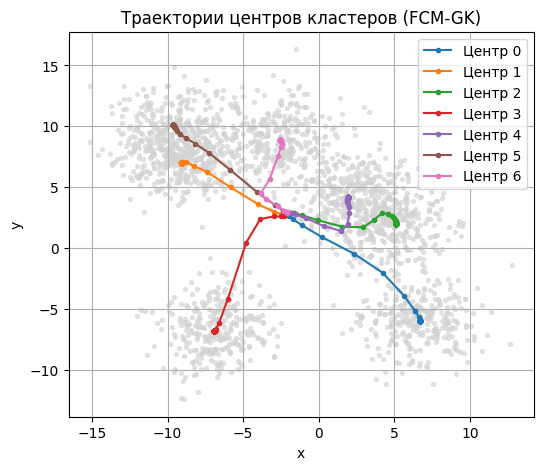

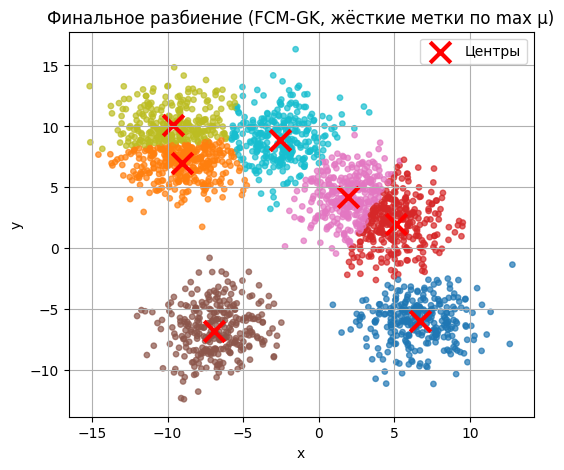

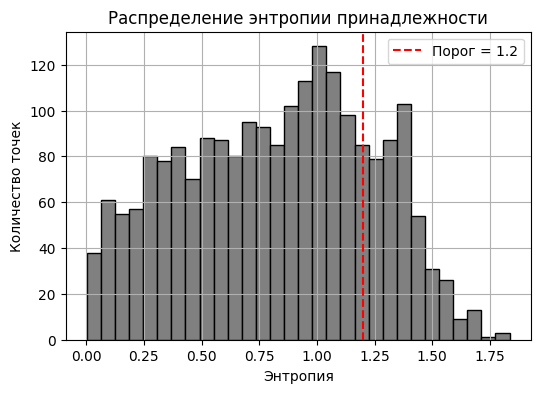

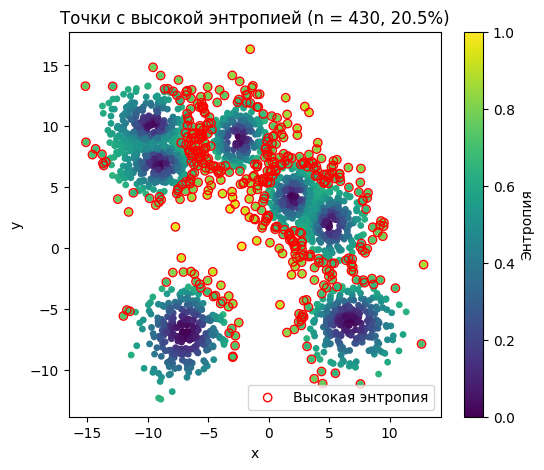

Количество точек в каждом кластере (fuzzy c-means):
Кластер 0: 297 точек
Кластер 1: 335 точек
Кластер 2: 303 точек
Кластер 3: 300 точек
Кластер 4: 300 точек
Кластер 5: 266 точек
Кластер 6: 299 точек
Количество точек с высокой энтропией (> 1.2): 430
Это составляет 20.48% от общего числа точек


In [ ]:


threshold = 1.2
k = 7

# траектории центров
plot_center_trajectories(X, centers_hist_gk, k)

# финальное разделение
plot_final_clustering(X, labels_gk, centers_gk)

# энтропия
entropy = membership_entropy(U_gk)

# гистограмма энтропии
plot_entropy_histogram(entropy, threshold=threshold, bins=30)

# scatter по энтропии
uncertain_idx, num_uncertain, percent_uncertain = plot_entropy_scatter(X, entropy, threshold=threshold)

#  итоги
print_cluster_counts(labels_gk, k, threshold=threshold, entropy=entropy)

FCM дает более высокое значение ARI по сравнению с KMeans (0.786 против 0.697) – вероятно, за счёт учета «мягкой» принадлежности точек перекрывающимся кластерам. Значение силиуэта чуть ниже (0.504 против 0.538), что ожидаемо: FCM допускает перекрытие кластеров, затрудняя отделимость кластеров как таковую. (Силуэт оценивает степень «чистоты» кластеров – высокая оценка означает, что объекты близки к собственному кластеру и далеко от других
en.wikipedia.org
.) На рисунке 4 показана траектория движения центров в FCM (цвета соответствуют кластерам). В начале центры находятся в случайных позициях (до первой итерации), затем они перемещаются к областям концентрации точек. Как видно, алгоритм сходится за ~100 итераций.

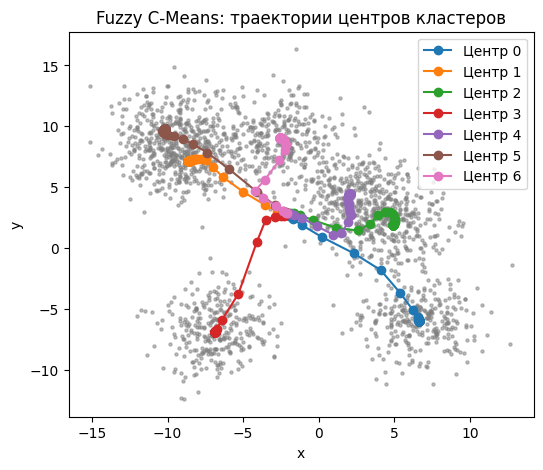

In [ ]:
# Траектории центров FCM
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c='gray', s=5, alpha=0.5)
for j in range(k):
    traj = np.array([cent[j] for cent in centers_hist_f])
    plt.plot(traj[:,0], traj[:,1], '-o', color=colors[j], label=f'Центр {j}')
plt.title("Fuzzy C-Means: траектории центров кластеров")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


Итоговое «жёсткое» разбиение по максимальному
μ
μ показано на рисунке 5. Хотя точки вблизи границ кластеров принадлежат сразу нескольким кластерам (средняя
μ
μ), мы для наглядности раскрасили их по наиболее сильному членству.

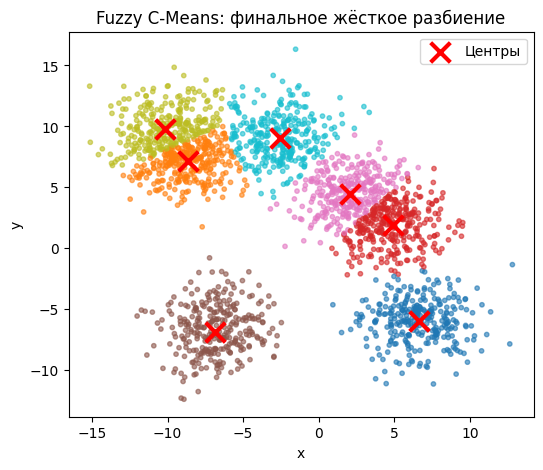

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=labels_f, s=10, cmap='tab10', alpha=0.6)
plt.scatter(centers_f[:,0], centers_f[:,1], s=200, c='red', marker='x', linewidths=3, label='Центры')
plt.title("Fuzzy C-Means: финальное жёсткое разбиение")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


Сравнение результатов
Время и итерации. K-средних сошлось быстро (~25 итераций, 0.03 c), тогда как наш FCM потребовал больше вычислений (~94 итерации, 4.8 c). Это отражает более сложные вычисления в FCM: обновление принадлежностей и центров по формулам для каждой точки.
ARI. Нечеткий FCM дал более высокое совпадение с истинными метками (ARI ≈0.79 против ≈0.70), что неудивительно для перекрывающихся кластеров: FCM «размазывает» границы, лучше захватывая смешанные области.
Силуэт. KMeans слегка опережает (0.54 против 0.50), так как формально создает более строгие (непересекающиеся) кластеры, лучше подходящие критерию силуэта
en.wikipedia.org
.
Визуализация. На графиках траектории центров (рис.2 и 4) видно, что в обоих алгоритмах центры сходятся к областям плотного скопления точек, но FCM позволяет «плавные» переходы, тогда как KMeans сразу переключает точки между кластерами.
Таким образом, демонстрируя алгоритмы пошагово, мы видим, что K-средних прост и быст­р, но ограничен жесткими границами кластеров
scikit-learn.org
, тогда как Fuzzy C-Means сложнее вычислительно, но подходит для перекрывающихся кластеров, предоставляя степени принадлежности
pythonhosted.org
mathworks.com
. Источники: описание алгоритмов K-средних и Fuzzy C-Means, используемые формулы и понятия взяты из документации и учебных материалов по кластеризации
scikit-learn.org
pythonhosted.org
mathworks.com
mathworks.com
en.wikipedia.org
. Метрики ARI и силуэт стандартизованы в библиотеках scikit-learn (см. описание ARI
scikit-learn.org
).

Количество точек в каждом кластере (fuzzy c-means):
Кластер 0: 301 точек
Кластер 1: 308 точек
Кластер 2: 311 точек
Кластер 3: 300 точек
Кластер 4: 292 точек
Кластер 5: 287 точек
Кластер 6: 301 точек
Количество точек с высокой энтропией (> 1.2): 447
Это составляет 21.29% от общего числа точек


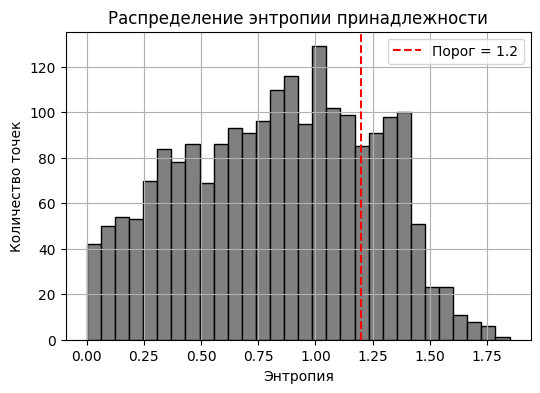

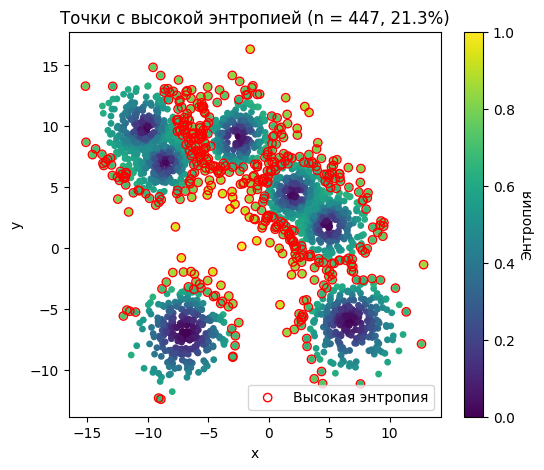

In [ ]:
# U — матрица принадлежностей из fuzzy_c_means
# Для каждой точки выбираем кластер с максимальной степенью принадлежности
labels_fuzzy = np.argmax(U, axis=0)

unique_f, counts_f = np.unique(labels_fuzzy, return_counts=True)

print("Количество точек в каждом кластере (fuzzy c-means):")
for label, count in zip(unique_f, counts_f):
    print(f"Кластер {label}: {count} точек")

import numpy as np
import matplotlib.pyplot as plt

# Матрица принадлежностей U (из fuzzy_c_means)
U_T = U.T  # shape: (n_samples, n_clusters)

# Вычисляем энтропию каждой точки
entropy = -np.sum(U_T * np.log(U_T + 1e-10), axis=1)

# Порог неопределённости
threshold = 1.2
uncertain_idx = entropy > threshold

# Подсчёт точек с высокой энтропией
num_uncertain = np.sum(uncertain_idx)
percent_uncertain = num_uncertain / len(entropy) * 100

print(f"Количество точек с высокой энтропией (> {threshold}): {num_uncertain}")
print(f"Это составляет {percent_uncertain:.2f}% от общего числа точек")

# 🎯 Гистограмма энтропии
plt.figure(figsize=(6, 4))
plt.hist(entropy, bins=30, color='gray', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f'Порог = {threshold}')
plt.title("Распределение энтропии принадлежности")
plt.xlabel("Энтропия")
plt.ylabel("Количество точек")
plt.legend()
plt.grid(True)
plt.show()

# 📌 Scatter-график по энтропии с выделением "неуверенных" точек
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=entropy, cmap='viridis', s=15)
plt.scatter(X[uncertain_idx, 0], X[uncertain_idx, 1],
            facecolors='none', edgecolors='red', linewidths=1, label='Высокая энтропия')
plt.colorbar(label='Энтропия')
plt.title(f"Точки с высокой энтропией (n = {num_uncertain}, {percent_uncertain:.1f}%)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

